## SPUR Densification Survey- Natural Langugage Processing Project
notebook author: Emily Robitschek

#### Background information on survey: 
This survey was conducted by the SPUR group at ETH: https://spur.ethz.ch/

#### Hypothesis/Research question: 
Can we use the open text field responses from densification surveys to infer something about the motivations behind why individuals responded the way they did to the densification survey?

#### Detailed notes and pre-processing based on preliminary inspection of the corpus
Initially, the raw data from the Chicago survey text responses (see Figure 1 for examples) was examined to identify potential caveats and preprocessing steps needed to properly prepare the data for analysis. In the process it was observed that:
1)	Response length varies greatly, with shorter responses more often (but not always) being "throw away" responses that are either somewhat random (e.g. "Fyfgfx" or "Bzsbsnsbsn") or unrelated to the survey or displaying a sort of bored, uncertain or apathetic attitude (or maybe they were just tired of filling out the survey at that point - the interpretation is difficult). Examples include: "Idk", "Nope", "Favor", "Nigh", "40", "I’m not yo I’m not talking to you".

2)	Even in substantive responses, spelling errors can significantly change the meanings of the responses. For instance, in the case of the response "Because it would be more far to people that don't have much") - this person clearly meant "fair" not "far", and in the case of "I think the 10 percent is to high of a yearly increase" - this person clearly meant "too" not "to". Also, slang words appear quite often within responses so filtering/interpreting those terms will add a potentially challenging element as well. 

For the variations described in point 1 of the discussion of the raw data, these patterns might be informative in and of themselves if they relate reliably and systematically to preferences for certain densification policies determine from the more quantitative aspects of the survey. These responses could even potentially speak to sentiments like lack of trust or lack of knowledge which are likely to influence policy views. However, the interpretation of such an analysis, especially if no specific words relevant to the policies are mentioned, would be challenging as the response character is confounded by other factors like sampling biases and the difficulty/impossibility of inferring the true motivations behind the response. For example, if someone says "I don't know" it is not clear if they don't know which policy to pick or if they don't know what else to say for the text response or if they are simply tired of filling out the survey and want it to be over. For point 2, greater length is not always directly indicative of a more meaningful response but in our case we might address some of the issues of varying response lengths by setting an initial cutoff.


## Stage 1: Pre-processing and analysis of response length

To ensure that the model has the best possible input data and therefore the best chance of generating useful and interpretable outputs in the form of topics and keywords related to densification, quality control and preprocessing was undertaken. Once this was completed, 4886 survey responses remained.

In [1]:
## import necessary packages: 

import pandas as pd
import numpy as np

#graphing/visualization packages: 
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

In [2]:
## Helper functions
def filter_response_df(response_df, open_text_column, min_char=0):
    """
    Takes in a dataframe for survey responses (response_df) and the column with the open text field of 
    interest (open_text_column) and a minimum character limit (automatically set at zero for no filtering) 
    and returns a dataframe with the null responses for that column filtered out and if min_char > 0, also 
    filters out responses shorter than or equal to the min_char limit.
    """
    #filter na responses
    response_df = response_df.dropna(subset=[open_text_column])
    #calculate character lengths of all non-NA responses
    response_char_length = []
    for i in range(0, len(response_df)):
        char_length = len(response_df[open_text_column][i])
        #if char_length < 10: ## if want to look at some of the responses for short character lengths
        #    print(response_df[open_text_column][i])
            #print(char_length)
        response_char_length.append(char_length)
    response_df['response_char_length'] = response_char_length
    if min_char > 0: 
        return response_df[response_df['response_char_length'] > min_char].copy()
    else: 
        return response_df

def encode_cat(df, column, ordinal=False): 
    if ordinal == True: 
        ord_enc = OrdinalEncoder()
        df[('%s_cat' % column)] = ord_enc.fit_transform(df[[column]])
    else: 
        df[column] = df[column].astype('category')
        df[('%s_cat' % column)] = df[column].cat.codes
    return df


## Read in data

### Generate dataframe to spell correct for cities besides Chicago all at once

In [3]:
#load in survey dataframe
filepath = '../../../Data_Emily/Densification_Survey/df_spell_corr.csv'
df_to_spell_correct = pd.read_csv(filepath)
print(len(df_to_spell_correct))

#select only responses from the English-speaking cities 
df_to_spell_correct = df_to_spell_correct[df_to_spell_correct['city'].isin(['Chicago', 'New York', 'Los Angeles', 'London'])]
print(len(df_to_spell_correct))

#view column with text response
df_to_spell_correct['Q12.6']

#read in Chicago responses (already spell corrected prior to the other three cities)
chicago_spell_corrected_file = '../../../Data_Emily/Densification_Survey/Chicago_original_spellcor.csv'
chicago_sp_corr_df = pd.read_csv(chicago_spell_corrected_file, 
                                 encoding='latin-1', 
                                 skiprows=[1,2])

#merge data and see how many responses there are per city and what the data looks like
df_to_spell_correct = df_to_spell_correct.merge(chicago_sp_corr_df[['ResponseId', 'Q12.6_corrected']], how='left', left_on='ResponseId', right_on='ResponseId')
print(df_to_spell_correct.city.value_counts())
df_to_spell_correct[['ResponseId', 'Q12.6', 'Q12.6_corrected']].head()

#specify an output file to write out respondent id and responses in order to spell correct the responses 
#for the other three cities

#out_file = '../../../Data_Emily/Densification_Survey/df_short_responses_spell_correct.csv'
#df_to_spell_correct[['ResponseId', 'Q12.6', 'Q12.6_corrected', 'city']].to_csv(out_file)

/Users/emilyrobitschek/opt/anaconda3/envs/relatio_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (26,41,99,102,104,106,108,109,110,148) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


12611
8479
Chicago        2120
London         2120
New York       2120
Los Angeles    2119
Name: city, dtype: int64


/Users/emilyrobitschek/opt/anaconda3/envs/relatio_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (254,260,276,376,504) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ResponseId,Q12.6,Q12.6_corrected
0,R_2dAqH8oUCTPTMfN,Great deal,Great deal
1,R_2X1HpxcUtZEpWYk,Goo,Good
2,R_10PI5FKTTlId8Ec,I’m not yo I’m not talking to you,I'm not yo I'm not talking to you
3,R_1gduid1fizdQ4d8,It is the way it is,It is the way it is
4,R_23WCgmyuPAy3b1G,Because it would be more far to people that do...,Because it would be more fair to people that d...


### Read in survey and spell corrected responses to merge 

In [4]:
#load in survey dataframe
filepath = '../../../Data_Emily/Densification_Survey/df_spell_corr.csv'
df_to_spell_correct = pd.read_csv(filepath)
print('Number of responses for all 6 cities in the survey: ', len(df_to_spell_correct))

#select only responses from the English-speaking cities 
df_to_spell_correct = df_to_spell_correct[df_to_spell_correct['city'].isin(['Chicago', 'New York', 'Los Angeles', 'London'])]
print('Number of responses for the 4 English-speaking cities in the survey: ', len(df_to_spell_correct))

## load in spell corrected responses: 
spellcorrected_file = '../../../Data_Emily/Densification_Survey/df_short_responses_spell_correct_v1.csv'
spell_corrected_df = pd.read_csv(spellcorrected_file, encoding='latin-1')

#fill the na values with a single letter so they can be included in the response length comparison across respondent characteristics
spell_corrected_df = spell_corrected_df.fillna(value='N')  

#merge the two dataframes
survey_response_df = df_to_spell_correct.merge(spell_corrected_df[['ResponseId', 'Q12.6_corrected']], 
                                                     how='left', left_on='ResponseId', right_on='ResponseId')

#specify column with corrected text
subset_col = 'Q12.6_corrected'

#run this function without filtering to generete the response_char_length parameter 
response_df = filter_response_df(survey_response_df, subset_col, min_char=0)
response_df = response_df.drop(columns=(['Unnamed: 0'])) # drop extra columns from filtering

print('Number of responses after merge and filter: ', len(response_df))
response_df.head(10)

#save to file: 
#response_df.to_csv('../../datasets/spur_survey_responses_english_spellcor.txt', index=False, sep='\t')

/Users/emilyrobitschek/opt/anaconda3/envs/relatio_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (26,41,99,102,104,106,108,109,110,148) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


Number of responses for all 6 cities in the survey:  12611
Number of responses for the 4 English-speaking cities in the survey:  8479
Number of responses after merge and filter:  8479


,StartDate,EndDate,Progress,Duration..in.seconds.,Finished,RecordedDate,ResponseId,LocationLatitude,LocationLongitude,UserLanguage,...,Q14.1_1,Q14.3,Q14.5,Q14.7,Q14.9,age,city,country,Q12.6_corrected,response_char_length
0,18.02.21 05:46,18.02.21 05:59,100.0,810.0,Richtig,18.02.21 05:59,R_2dAqH8oUCTPTMfN,44.013794,-107.956299,EN-GB,...,0.0,10.0,5.0,Very concerned,Very concerned,25-34,Chicago,United States,Great deal,10
1,18.02.21 06:05,18.02.21 06:11,100.0,327.0,Richtig,18.02.21 06:11,R_2X1HpxcUtZEpWYk,41.675095,-87.732002,EN-GB,...,5.0,3.0,4.0,Neither,Rather not concerned,25-34,Chicago,United States,Good,5
2,18.02.21 06:18,18.02.21 06:23,100.0,300.0,Richtig,18.02.21 06:23,R_10PI5FKTTlId8Ec,41.606201,-87.259300,EN-GB,...,5.0,6.0,6.0,Quite concerned,Neither,18-24,Chicago,United States,I'm not yo I'm not talking to you,34
3,18.02.21 06:41,18.02.21 06:55,100.0,894.0,Richtig,18.02.21 06:55,R_1gduid1fizdQ4d8,37.983398,-122.031204,EN-GB,...,6.0,9.0,9.0,Very concerned,Very concerned,35-44,Chicago,United States,It is the way it is,19
4,18.02.21 06:45,18.02.21 06:57,100.0,681.0,Richtig,18.02.21 06:57,R_23WCgmyuPAy3b1G,41.741501,-87.596199,EN-GB,...,1.0,9.0,4.0,Very concerned,Very concerned,18-24,Chicago,United States,Because it would be more fair to people that d...,60
5,18.02.21 06:56,18.02.21 07:11,100.0,941.0,Richtig,18.02.21 07:11,R_1pLEMXp5iJbankG,41.920898,-87.704300,EN-GB,...,7.0,10.0,5.0,Neither,Neither,35-44,Chicago,United States,I choose proposal 2 because you offered me bet...,74
6,18.02.21 09:22,18.02.21 09:27,100.0,265.0,Richtig,18.02.21 09:27,R_w5xohvakFFVFRtL,41.761993,-87.570297,EN-GB,...,4.0,3.0,9.0,Quite concerned,Quite concerned,18-24,Chicago,United States,Mhmmm girl,10
7,18.02.21 09:38,18.02.21 09:50,100.0,676.0,Richtig,18.02.21 09:50,R_2OYEXKWutkzQOmS,42.048706,-87.890503,EN-GB,...,1.0,8.0,9.0,Very concerned,Very concerned,18-24,Chicago,United States,Because I felt like it wouldn't be good enough...,54
8,18.02.21 09:50,18.02.21 09:55,100.0,334.0,Richtig,18.02.21 09:55,R_2ipd5d0ZqN9yJXj,41.850204,-87.673599,EN-GB,...,5.0,8.0,9.0,Quite concerned,Very concerned,35-44,Chicago,United States,I don't know,12
9,18.02.21 09:46,18.02.21 09:59,100.0,771.0,Richtig,18.02.21 09:59,R_1PY5daqTS4xhkV9,41.848602,-87.628799,EN-GB,...,2.0,4.0,3.0,Rather not concerned,Quite concerned,55+,Chicago,United States,no comment,10


### Compute some summary statistics for response length across cities

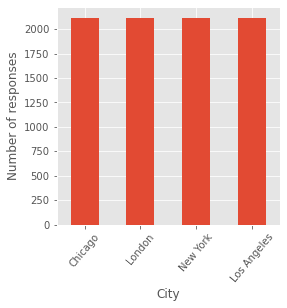

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
Chicago,2120.0,45.331132,61.868368,1.0,4.0,28.0,62.25,880.0
London,2120.0,48.066509,70.818026,1.0,3.0,28.0,65.00,1468.0
Los Angeles,2119.0,36.546956,51.911621,1.0,3.0,19.0,49.00,505.0
New York,2120.0,40.725943,68.472141,1.0,3.0,21.0,59.00,1969.0


In [5]:
plt.figure(figsize=(4,4))

# Groupby by city
city_initial = response_df.groupby("city")

city_initial.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("City")
plt.ylabel("Number of responses")
plt.show()

# Summary statistic of all countries
city_initial['response_char_length'].describe().head()

### Correlations of response length and other survey variables
Because response length itself could vary based on respondent characteristics, the spearman correlation was computed between the response lengths (NaN responses were counted to have a length of 1 character, to try to account for bias in who even attempted to fill out the text response) and a subset of other metadata columns in the survey, including potential covariates of response length (e.g. age, income, minority status, location) before length filtering and after length filtering. Project location was encoded with a categorical encoder for inclusion. The resulting correlations were sorted in a descending manner for display.  


In [6]:
response_df = encode_cat(response_df, 'projectLocation', ordinal=False) #encode project location for correlation

cols = ['LocationLatitude', 'LocationLongitude', 'UserLanguage', 'Q3.1', 'Q3.3', 'Q3.5', 'Q3.7', 'Q3.9', 
        'minority', 'linguistic_minority', 'religious_minority', 'social_class_minority', 
        'sexual_orientation_minority', 'ethnic_minority', 'national_minority', 'no_answer', 'other_minority', 
        'disabled_minority', 'Q3.9_7_TEXT', 'Q3.11', 'Q3.13_1', 'Q3.13_2', 'Q3.13_3', 'Q3.13_TOTAL', 'Q3.16', 
        'Q4.1', 'samedistrict', 'sameneighborhood', 'diffneighborhood', 'otherdistrict', 'projectLocation', 
        'frame', 'Q5.1', 'Q5.1_9_TEXT', 'Q5.3', 'Q5.5', 'Q5.5_9_TEXT', 'Q6.1', 'Q6.3_1', 'Q6.3_2', 'Q6.3_3', 
        'Q6.3_4', 'Q6.3_combined', 'Q6.5_1', 'Q6.5_2', 'Q6.5_3', 'Q6.5_4', 'Q6.5_5', 'Q6.5_6', 'Q6.5_7', 
        'Q6.5_8', 'Q6.5_9', 'Q6.5_10', 'Q6.7_1', 'Q6.7_2', 'Q6.7_3', 'Q6.7_4', 'Q6.7_5', 'Q6.7_6', 'Q6.9_1', 
        'Q6.9_2', 'Q6.9_3', 'Q6.9_4', 'Q6.9_5', 'Q6.9_6', 'Q6.9_7', 'Q6.11_1', 'Q6.11_2', 'Q6.11_3', 
        'Q6.11_4', 'Q6.13_1', 'Q6.13_2', 'Q6.13_3', 'Q6.13_4', 'Q6.15_1', 'Q6.15_2', 'Q6.15_3', 'Q6.15_4', 
        'Q6.15_5', 'Q6.15_6', 'Q6.15_7', 'Q6.15_8', 'Q7.5', 'Q7.6', 'Q7.7', 'Q12.6', 'Q13.2', 'Q13.3', 'Q13.4', 
        'Q13.5', 'Q13.6', 'Q13.6_8_TEXT', 'Q13.8', 'Q13.10', 'Q13.10_5_TEXT', 'Q13.12', 'Q13.12_8_TEXT', 'Q13.14', 
        'Q13.14_5_TEXT', 'Q13.16', 'Q13.18', 'Q13.20', 'Q13.20_5_TEXT', 'Q13.22', 'Q13.22_4_TEXT', 'Q13.24', 
        'Q13.24_1_TEXT', 'Q13.26_1', 'Q13.28', 'Q13.30_1', 'Q13.32', 'Q13.34', 'Q13.36', 'Q13.38', 
        'moving_in_partner', 'desire_change_location', 'proximity_friends_family', 'acquisition_real_estate', 
        'education_opportunities', 'professionas_reasons', 'desire_better_property', 'growing_family', 
        'end_relationship', 'other_reason', 'Q13.38_11_TEXT', 'Q13.40', 'Q13.42', 'Q13.44', 'termination_lease', 
        'expiration_lease', 'family_reasons', 'financial_reasons', 'rising_rent', 'house_demolish_renovation', 
        'other_concern', 'Q13.44_7_TEXT', 'Q13.46', 'Q13.48', 'Q13.56', 'Q13.58', 'Q13.58_4_TEXT', 'Q13.60', 
        'Q13.62', 'Q13.64', 'Q14.1_1', 'Q14.3', 'Q14.5', 'Q14.7', 'Q14.9', 'age', 'city', 'country', 
        'Q12.6_corrected', 'response_char_length', 'projectLocation_cat'] 


df_corr= response_df[cols]

#drop variables that are NA for all values
df_corr = df_corr.dropna(axis=1, how='all')
df_corr.head()

,LocationLatitude,LocationLongitude,UserLanguage,Q3.1,Q3.3,Q3.5,Q3.7,Q3.9,minority,linguistic_minority,...,Q14.3,Q14.5,Q14.7,Q14.9,age,city,country,Q12.6_corrected,response_char_length,projectLocation_cat
0,44.013794,-107.956299,EN-GB,Male,30.0,4.0,US Born,No,0.0,0.0,...,10.0,5.0,Very concerned,Very concerned,25-34,Chicago,United States,Great deal,10,650
1,41.675095,-87.732002,EN-GB,Male,27.0,3.0,US Naturalization,Linguistic minority,1.0,1.0,...,3.0,4.0,Neither,Rather not concerned,25-34,Chicago,United States,Good,5,258
2,41.606201,-87.259300,EN-GB,Female,20.0,8.0,US Naturalization,"Religious minority,Social class minority",1.0,0.0,...,6.0,6.0,Quite concerned,Neither,18-24,Chicago,United States,I'm not yo I'm not talking to you,34,639
3,37.983398,-122.031204,EN-GB,Male,40.0,8.0,US Born,No,0.0,0.0,...,9.0,9.0,Very concerned,Very concerned,35-44,Chicago,United States,It is the way it is,19,515
4,41.741501,-87.596199,EN-GB,Female,21.0,5.0,US Born,"Religious minority,Sexual orientation minority",1.0,0.0,...,9.0,4.0,Very concerned,Very concerned,18-24,Chicago,United States,Because it would be more fair to people that d...,60,780


Text(0.5, 1.0, 'Correlation heatmap of response length and potential covariates')

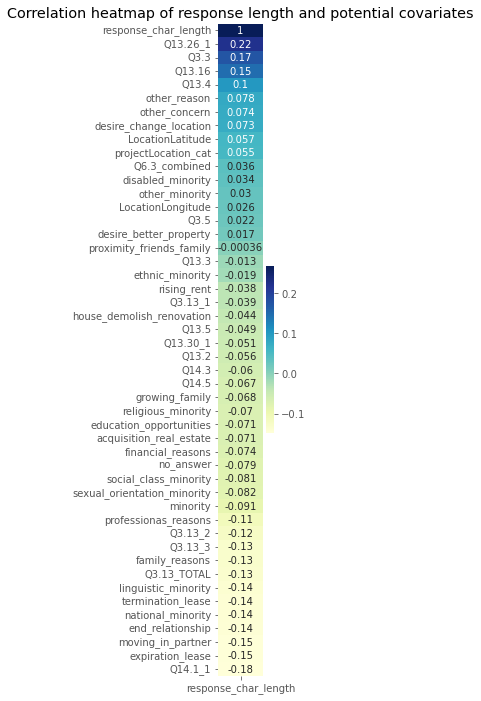

In [7]:
#make heatmap of plot above
plt.figure(figsize=(1, 12))
corr = df_corr.corr(method='spearman')
ax = sns.heatmap(corr[["response_char_length"]].sort_values(by=["response_char_length"], ascending=False),
                 robust=True, 
                 annot=True, 
                 cmap="YlGnBu")
title = ("Correlation heatmap of response length and potential covariates" )
plt.title(title)
#file_name=('../../figures/' + title + ('_v1_spearman.png'))
#plt.savefig((file_name), dpi=300, bbox_inches='tight')

### Data exploration: Lengths of responses (non-NA or 1 character length responses) for response length cut-off
We can notice that response length varies greatly, with shorter responses more often (but not always) being "throw away" responses that are either somewhat random (e.g. "Fyfgfx" or "Bzsbsnsbsn") or unrelated to the survey or displaying a sort of bored, uncertain or apathetic attitude (or maybe they were just tired of filling out the survey at that point - the interpretation is difficult). Examples include: "Idk", "Nope", "Favor", "Nigh", "40", "I’m not yo I’m not talking to you". Greater response length is not always directly indicative of a more meaningful response but in our case we might address some of the issues of varying response lengths by setting an initial cutoff. 

In [8]:
response_df = filter_response_df(response_df, subset_col, min_char=1) #filter nan and 1-character responses
response_df = response_df.reset_index()
response_df = response_df.drop(columns=(['index']))  # drop extra column from resetting the index
response_df["ln_response_char_length"] = response_df["response_char_length"].apply(lambda x: np.log(x))

print("There are %d entries for the text field in this dataset" % (len(response_df)))
response_df['response_char_length'].head()

There are 6704 entries for the text field in this dataset


0    10
1     5
2    34
3    19
4    60
Name: response_char_length, dtype: int64

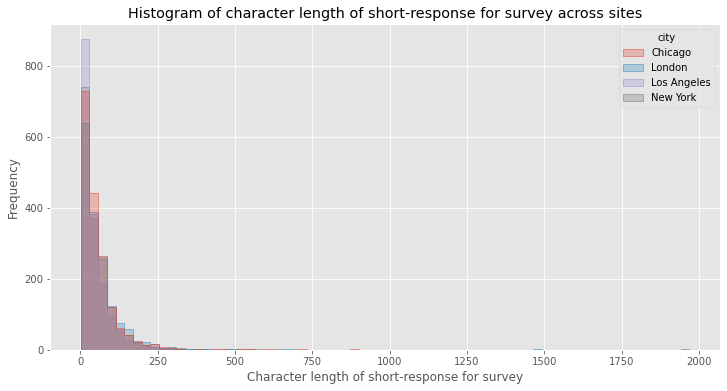

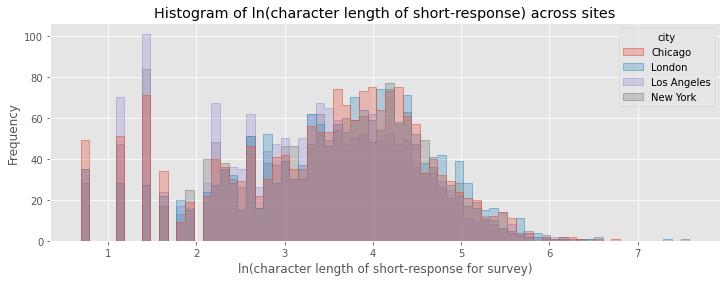

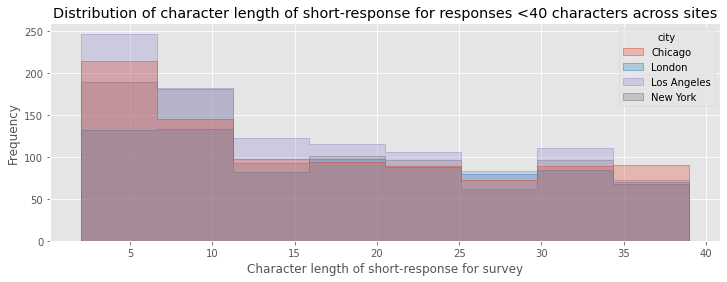

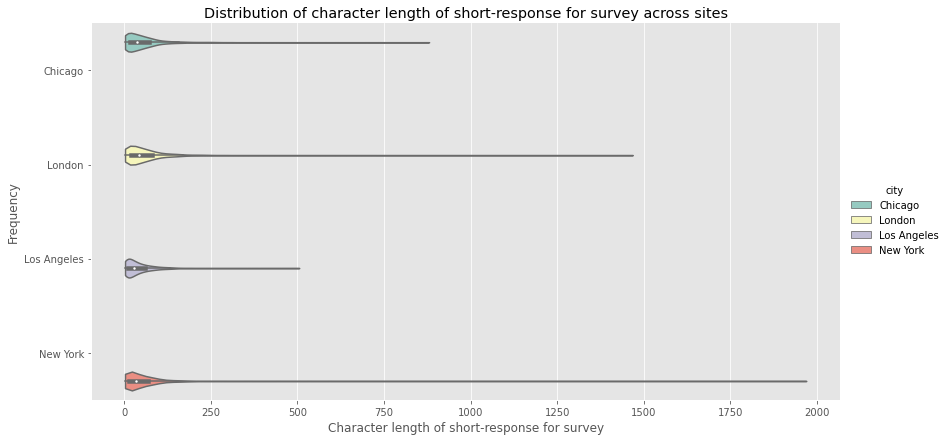

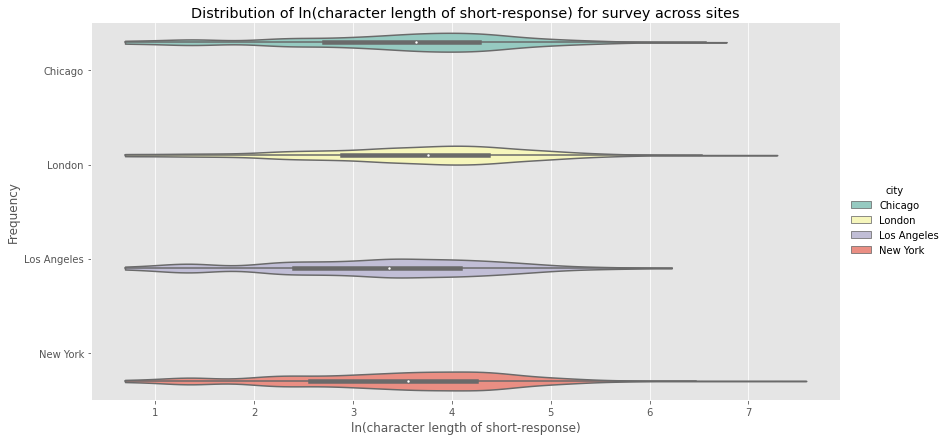

In [9]:
## Plot distribution of length of responses by city
#non-log data
plt.rcParams["figure.figsize"] = (12,6)
sns.histplot(data=response_df, x='response_char_length', bins=70, hue="city", alpha=0.3, element="step")
plt.xlabel("Character length of short-response for survey")
plt.ylabel("Frequency")
title = ("Histogram of character length of short-response for survey across sites")
plt.title(title)
file_name=('../../figures/' + title + ('_v1.png'))
#plt.savefig((file_name), dpi=300, bbox_inches='tight')
plt.show()

#log data
plt.rcParams["figure.figsize"] = (12,4)
sns.histplot(data=response_df, x="ln_response_char_length", bins=70, hue="city", alpha=0.3, element="step")
plt.xlabel("ln(character length of short-response for survey)")
plt.ylabel("Frequency")
title = ("Histogram of ln(character length of short-response) across sites")
plt.title(title)
file_name=('../../figures/' + title + ('_v1.png'))
#plt.savefig((file_name), dpi=300, bbox_inches='tight')
plt.show()

#non-log data for shorter responses
sns.histplot(data=response_df[response_df['response_char_length'] <40], x='response_char_length', bins=8, hue="city", alpha=0.3, element="step")
plt.xlabel("Character length of short-response for survey")
plt.ylabel("Frequency")
title = ("Distribution of character length of short-response for responses <40 characters across sites")
plt.title(title)
file_name=('../../figures/' + title + ('_v1.png'))
#plt.savefig((file_name), dpi=300, bbox_inches='tight')
plt.show()

#non-log data catplot
g = sns.catplot(x='response_char_length', y="city",
                hue="city", 
                data=response_df,
                orient="h", height=6, aspect=2, palette="Set3",
                kind="violin", dodge=True, cut=0, bw=.2)

plt.xlabel("Character length of short-response for survey")
plt.ylabel("Frequency")
title = ("Distribution of character length of short-response for survey across sites")
plt.title(title)
file_name=('../../figures/' + title + ('_v1_violins.png'))
#plt.savefig((file_name), dpi=300, bbox_inches='tight')

#log data catplot
g = sns.catplot(x="ln_response_char_length", y="city",
                hue="city", 
                data=response_df,
                orient="h", height=6, aspect=2, palette="Set3",
                kind="violin", dodge=True, cut=0, bw=.2)

plt.xlabel("ln(character length of short-response)")
plt.ylabel("Frequency")
title = ("Distribution of ln(character length of short-response) for survey across sites")
plt.title(title)
file_name=('../../figures/' + title + ('_v1_violins.png'))
#plt.savefig((file_name), dpi=300, bbox_inches='tight')


There are 4886 entries for the text field with less than 15 characters in this dataset


Text(0.5, 1.0, 'Distribution of character length of short-response for survey across sites')

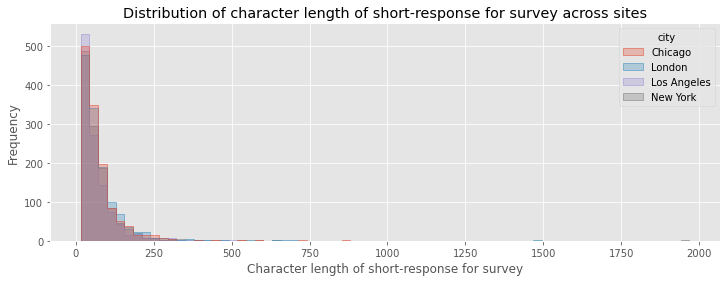

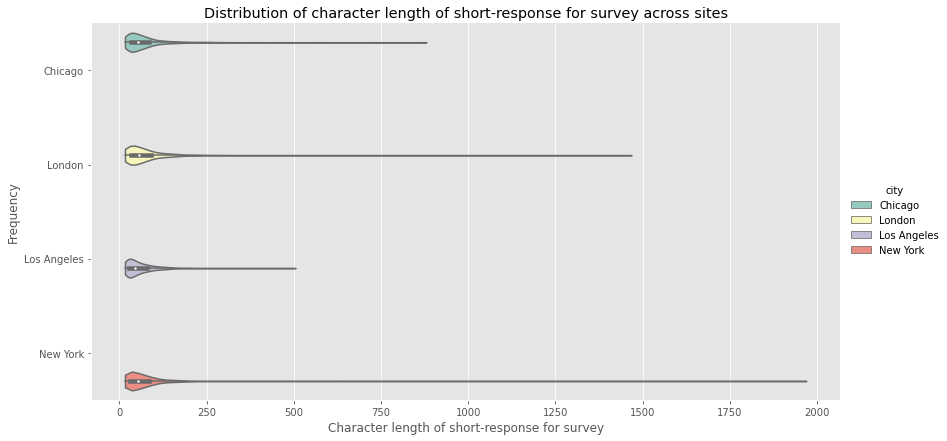

In [10]:
# cut out short responses for now of ~15 characters
min_char = 15 
response_df = filter_response_df(response_df, subset_col, min_char= min_char)  
response_df = response_df.reset_index()
response_df = response_df.drop(columns=(['index'])) # drop extra column from resetting the index

print("There are %d entries for the text field with less than %d characters in this dataset" % (len(response_df), min_char))
response_df['response_char_length'].head()

sns.histplot(data=response_df, x='response_char_length', bins=70, hue="city", alpha=0.3, element="step")
plt.xlabel("Character length of short-response for survey")
plt.ylabel("Frequency")
title = ("Distribution of character length of short-response for survey across sites")
plt.title(title)

g = sns.catplot(x='response_char_length', y="city",
                hue="city", 
                data=response_df,
                orient="h", height=6, aspect=2, palette="Set3",
                kind="violin", dodge=True, cut=0, bw=.2)

plt.xlabel("Character length of short-response for survey")
plt.ylabel("Frequency")
title = ("Distribution of character length of short-response for survey across sites")
plt.title(title)

### make correlation heatmap for data after 15 character minimum to see if response length remains not strongly correlated with other survey variables

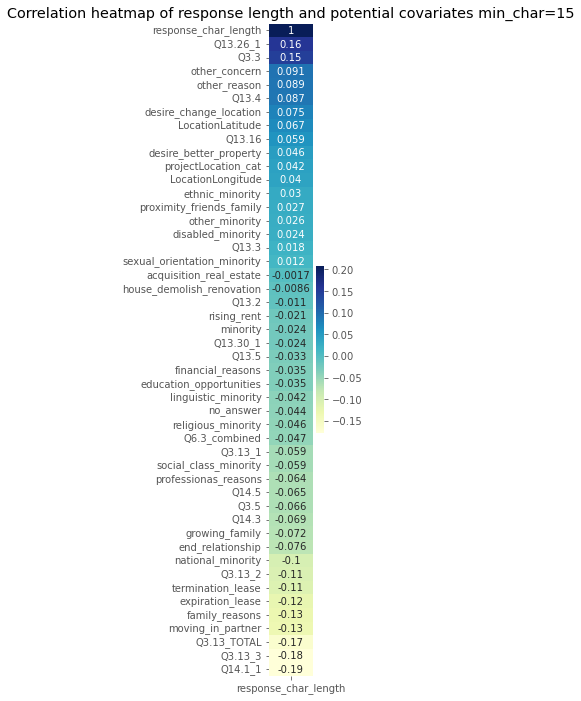

In [11]:
plt.figure(figsize=(1, 12))
df_corr = response_df[cols]
df_corr = df_corr.dropna(axis=1, how='all')

corr = df_corr.corr(method='spearman')
ax = sns.heatmap(corr[["response_char_length"]].sort_values(by=["response_char_length"], ascending=False),
                 robust=True, 
                 annot=True, 
                 cmap="YlGnBu")
title = ("Correlation heatmap of response length and potential covariates min_char=15" ) 
plt.title(title)
file_name=('../../figures/' + title + ('_v1_spearman.png'))
#plt.savefig((file_name), dpi=300, bbox_inches='tight')

### Discussion of how the corpus will help answer the research question
In addition to the open text field, the survey had many other structured questions to gauge participants responses to and feelings about densification projects and intersecting concerns at the community level (e.g. cost of living) and at a more global level (e.g. climate change concerns). Some examples include: 

    1) The frame on whether the project was situated in respondent’s own neighborhood/district or somewhere else
    2) Q7.5 on general acceptance of such densification projects 
    (alternatively also Q6.1 which is the same question but was asked before the frame)
    3) Q7.6 on the perceived effect of such projects on rent
    4) Q7.7 on the perceived effect of such projects on social cohesion & composition within the neighborhood
    5) Q14.9 on climate change concern

In order to compare and interpret the results of the analysis of the text responses with other key survey elements, a subset of these questions will be used to stratify respondents into subpopulations (e.g. those who always accept densification projects versus those that always reject them).

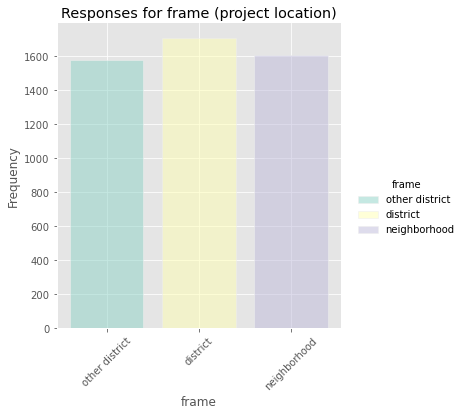

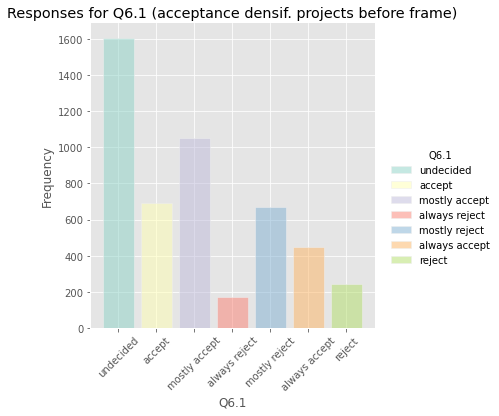

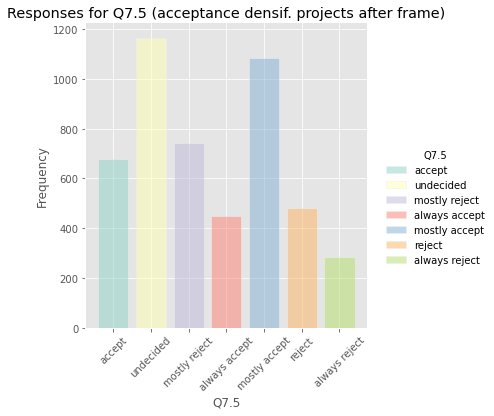

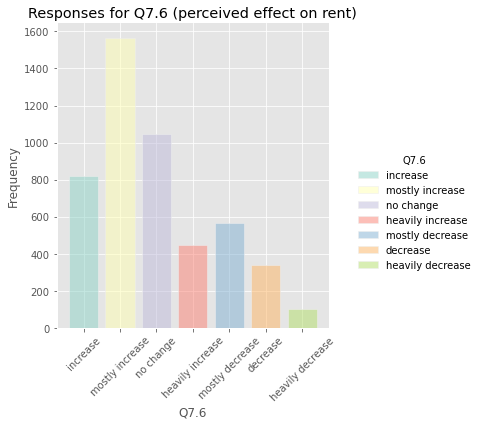

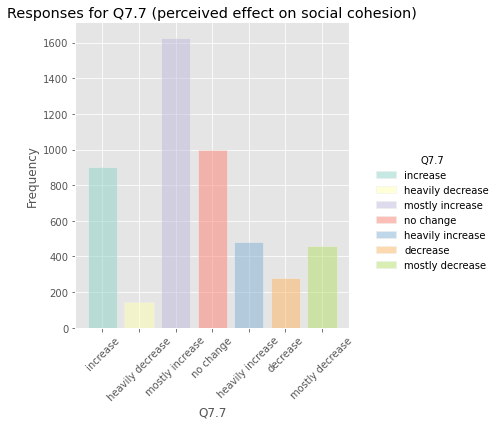

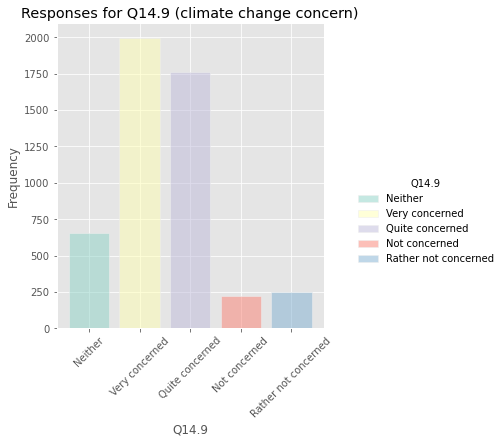

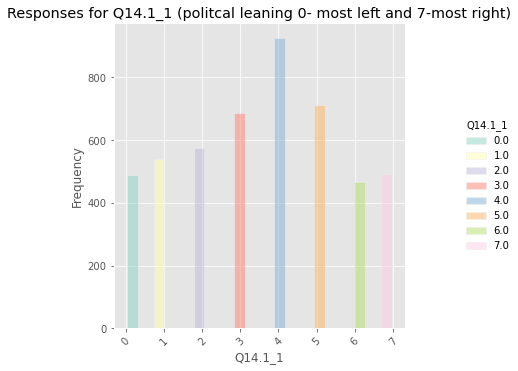

In [12]:
question = 'frame'
g = sns.displot(response_df, x=question, hue=question, palette="Set3", shrink=.8)
plt.xlabel(question)
plt.xticks(rotation=45)
plt.ylabel("Frequency")
title = ("Responses for %s (project location)" % question)
plt.title(title)
file_name=('../../figures/survey_characteristics_bar/' + title + ('_v1_minchar15_bar.png'))
#plt.savefig(file_name, dpi=300, bbox_inches='tight')
plt.show()

question = 'Q6.1'
g = sns.displot(response_df, x=question, hue=question, palette="Set3", shrink=.8)
plt.xlabel(question)
plt.xticks(rotation=45)
plt.ylabel("Frequency")
title = ("Responses for %s (acceptance densif. projects before frame)" % question)
plt.title(title)
file_name=('../../figures/survey_characteristics_bar/' + title + ('_v1_minchar15_bar.png'))
#plt.savefig((file_name), dpi=300, bbox_inches='tight')
plt.show()

question = 'Q7.5'
g = sns.displot(response_df, x=question, hue=question, palette="Set3", shrink=.8)
plt.xlabel(question)
plt.xticks(rotation=45)
plt.ylabel("Frequency")
title = ("Responses for %s (acceptance densif. projects after frame)" % question)
plt.title(title)
file_name=('../../figures/survey_characteristics_bar/' + title + ('_v1_minchar15_bar.png'))
#plt.savefig((file_name), dpi=300, bbox_inches='tight')
plt.show()

question = 'Q7.6'
g = sns.displot(response_df, x=question, hue=question, palette="Set3", shrink=.8)
plt.xlabel(question)
plt.xticks(rotation=45)
plt.ylabel("Frequency")
title = ("Responses for %s (perceived effect on rent)" % question)
plt.title(title)
file_name=('../../figures/survey_characteristics_bar/' + title + ('_v1_minchar15_bar.png'))
#plt.savefig((file_name), dpi=300, bbox_inches='tight')
plt.show()

question = 'Q7.7'
g = sns.displot(response_df, x=question, hue=question, palette="Set3", shrink=.8)
plt.xlabel(question)
plt.xticks(rotation=45)
plt.ylabel("Frequency")
title = ("Responses for %s (perceived effect on social cohesion)" % question)
plt.title(title)
file_name=('../../figures/survey_characteristics_bar/' + title + ('_v1_minchar15_bar.png'))
#plt.savefig((file_name), dpi=300, bbox_inches='tight')
plt.show()

question = 'Q14.9'
g = sns.displot(response_df, x=question, hue=question, palette="Set3", shrink=.8)
plt.xlabel(question)
plt.xticks(rotation=45)
plt.ylabel("Frequency")
title = ("Responses for %s (climate change concern)" % question)
plt.title(title)
file_name=('../../figures/survey_characteristics_bar/' + title + ('_v1_minchar15_bar.png'))
#plt.savefig((file_name), dpi=300, bbox_inches='tight')
plt.show()

question = 'Q14.1_1' #survey question on political views
g = sns.displot(response_df, x=question, hue=question, palette="Set3", shrink=.8)
plt.xlabel(question)
plt.xticks(rotation=45)
plt.ylabel("Frequency")
title = ("Responses for %s (politcal leaning 0- most left and 7-most right)" % question)
plt.title(title)
file_name=('../../figures/survey_characteristics_bar/' + title + ('_v1_minchar15_bar.png'))
#plt.savefig((file_name), dpi=300, bbox_inches='tight')
plt.show()

### Export dataframe post filtering

In [13]:
response_df = pd.read_csv('../../datasets/spur_survey_responses_english_spellcor.txt', sep='\t')
response_df = filter_response_df(response_df, subset_col, min_char= min_char)  
response_df = response_df.reset_index()
response_df = response_df.drop(columns=(['index'])) # drop extra column from resetting the index
#response_df.to_csv('../../datasets/spur_survey_response_filtered_df1.txt', index=False, sep='\t')

/Users/emilyrobitschek/opt/anaconda3/envs/relatio_env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3251: DtypeWarning: Columns (105,107,109,148) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


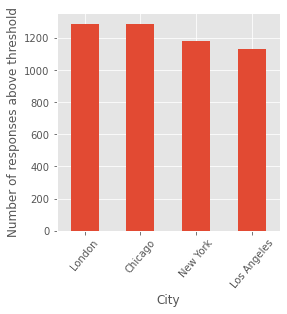

,count,mean,std,min,25%,50%,75%,max
city,,,,,,,,
Chicago,1286.0,71.794712,67.213452,16.0,33.00,53.0,84.0,880.0
London,1291.0,76.358637,78.594509,16.0,33.00,56.0,91.0,1468.0
Los Angeles,1130.0,64.392920,58.093672,16.0,28.25,46.0,80.0,505.0
New York,1179.0,69.793045,80.706733,16.0,31.00,52.0,84.0,1969.0


In [14]:
# Groupby by city
city = response_df.groupby("city")

plt.figure(figsize=(4,4))
city.size().sort_values(ascending=False).plot.bar()
plt.xticks(rotation=50)
plt.xlabel("City")
plt.ylabel("Number of responses above threshold")
plt.show()

# Summary statistic of all countries
city['response_char_length'].describe().head()

In [15]:
#see if the dataframe wrote out properly
#test = pd.read_csv('../../datasets/spur_survey_response_filtered_df1.txt', sep='\t')
#test.head()